In [1]:
import folium 
import gpxpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from xml.etree import ElementTree as ET
from xml.dom import minidom
import math  
from IPython.core import display as ICD

In [2]:
def overviewGPX(filepath):
    
    '''
    parsing and showing an overview description of any GPS device tracked route.
    examples from a mountain hike dataset made in Wyoming, US
    '''

    #1. read gpx file
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)
    
    #2. Each track: name, length, duration, average speed, start point, end point
    for track in gpx.tracks:

        print('Track name:', track.name)
        
        lenghts_2d = round(track.length_2d()/1000,2)
        lenghts_3d = round(track.length_3d()/1000,2)
        print('Track 2D lenghts:', lenghts_2d, 'km')
        print('Track 3D lenghts:', lenghts_3d, 'km') # with elevation
        
        Duration = track.get_time_bounds().end_time - track.get_time_bounds().start_time
        print('Duration:', str(Duration))
        
        print('Avg speed:', round(lenghts_2d/(Duration.seconds/3600), 2))
        
        start_point = track.get_location_at(track.get_time_bounds().start_time)[0]
        end_point = track.get_location_at(track.get_time_bounds().end_time)[0]
        print(f'Start point at: {start_point.latitude},{start_point.longitude},{start_point.elevation}')
        print(f'End point at: {end_point.latitude},{end_point.longitude},{end_point.elevation}')

In [3]:
def plotElevation(filepath):

    '''
    plot elevation profile from a GPX route
    Note that this function was adapted from
    https://www.geodose.com/2018/04/create-gpx-tracking-file-visualizer-python.html
    '''

    #READ GPX FILE
    data=open(filepath)
    xmldoc = minidom.parse(data)
    track = xmldoc.getElementsByTagName('trkpt')
    elevation=xmldoc.getElementsByTagName('ele')
    datetime=xmldoc.getElementsByTagName('time')
    n_track=len(track)

    #PARSE GPX FILE
    lon_list=[]
    lat_list=[]
    h_list=[]
    time_list=[]
    for s in range(n_track):
        lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
        elev=elevation[s].firstChild.nodeValue
        lon_list.append(float(lon))
        lat_list.append(float(lat))
        h_list.append(float(elev))

        # PARSING TIME ELEMENT
        dt=datetime[s].firstChild.nodeValue
        time_split=dt.split('T')
        hms_split=time_split[1].split(':')
        time_hour=int(hms_split[0])
        time_minute=int(hms_split[1])
        time_second=int(hms_split[2].split('Z')[0])
        total_second=time_hour*3600+time_minute*60+time_second
        time_list.append(total_second)

    #DEFINE HELPER FUNCTIONS
    def geo2cart(lon,lat,h):
        a=6378137 #WGS 84 Major axis
        b=6356752.3142 #WGS 84 Minor axis
        e2=1-(b**2/a**2)
        N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
        X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
        Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
        return X,Y

    def distance(x1,y1,x2,y2):
        d=math.sqrt((x1-x2)**2+(y1-y2)**2)
        return d

    #POPULATE DISTANCE LIST
    d_list=[0.0]
    l=0
    for k in range(n_track-1):
        if k<(n_track-1):
            l=k+1
        else:
            l=k
        XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
        XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])   
        #DISTANCE
        d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
        sum_d=d+d_list[-1]
        d_list.append(sum_d)

    #PLOT TRACK
    f,(track,elevation)=plt.subplots(1,2)
    f.set_figheight(4) 
    f.set_figwidth(12) 
    plt.subplots_adjust(hspace=0.5)
    track.plot(lon_list,lat_list,'k')
    track.set_ylabel("Latitude")
    track.set_xlabel("Longitude")
    track.set_title("Route Traveled")

    #PLOT ELEVATION PROFILE
    base_reg=9000
    elevation.plot(d_list,h_list)
    elevation.fill_between(d_list,h_list,base_reg,alpha=0.1)
    elevation.set_title("Elevation Profile")
    elevation.set_xlabel("Distance (meteres)")
    elevation.set_ylabel("Elevation (meteres)")
    elevation.grid()

In [4]:
def plotMap(filepath, zoom):
    
    '''
    overlay a gpx route on top of an OSM map using Folium
    some portions of this function were adapted
    from this post: https://stackoverflow.com/questions/54455657/
    how-can-i-plot-a-map-using-latitude-and-longitude-data-in-python-highlight-few
    '''
    
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)
    points = []
    for track in gpx.tracks:
        for segment in track.segments:        
            for point in segment.points:
                points.append(tuple([point.latitude, point.longitude]))
    latitude = sum(p[0] for p in points)/len(points)
    longitude = sum(p[1] for p in points)/len(points)
    myMap = folium.Map(location=[latitude,longitude],zoom_start=zoom)
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(myMap)
    return (myMap)

In [6]:
filepath = 'Laramie_Enduro_2014.gpx'
overviewGPX(filepath)

Track name: 2014 Laramie Enduro
Track 2D lenghts: 110.04 km
Track 3D lenghts: 110.3 km
Duration: 7:52:30
Avg speed: 13.97
Start point at: 41.233283,-105.434187,2606.7
End point at: 41.233234,-105.434079,2606.6


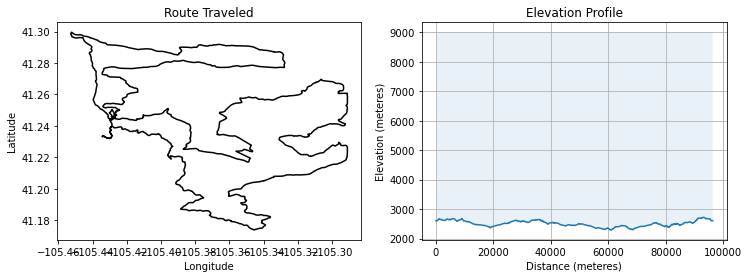

In [8]:
plotElevation(filepath)

In [9]:
plotMap(filepath, 7)